In [16]:
import math
import numpy as np
import torch
import gpytorch
import pandas as pd
from pyDOE2 import lhs
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood
from scipy.stats import qmc
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

###################
# Define GP Model #
###################

class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims = 3))


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)
    
# Scale inputs to the desired ranges
def scale_inputs(x, voltage_bounds, time_bounds, concentration_bounds,
                 voltage_target, time_target, concentration_target):
    # Unpack x
    voltage, time, concentration = x[:, 0], x[:, 1], x[:, 2]
    
    # Scale voltage
    voltage_scaled = voltage_target[0] + ((voltage - voltage_bounds[0]) * 
                                          (voltage_target[1] - voltage_target[0]) / 
                                          (voltage_bounds[1] - voltage_bounds[0]))
    
    # Scale time
    time_scaled = time_target[0] + ((np.vectorize(math.log)(time) - math.log(time_bounds[0])) * 
                                    (time_target[1] - time_target[0]) / 
                                    (math.log(time_bounds[1]) - math.log(time_bounds[0])))
    
    # Scale concentration 
    concentration_scaled = concentration_target[0] + ((np.vectorize(math.log)(concentration) - math.log(concentration_bounds[0])) * 
                                                      (concentration_target[1] - concentration_target[0]) / 
                                                      (math.log(concentration_bounds[1]) - math.log(concentration_bounds[0])))
    
    # Combine back into a single array
    x_scaled = np.stack((voltage_scaled, time_scaled, concentration_scaled), axis=1)
    return x_scaled

# Import training data and convert to Pytorch tensors
#data_df = pd.read_csv('D:\\1-PhD\\2-PANDA-BEAR\\DataAnalysis\\PEDOT\\ML\\MLTrainingDataHC.csv')
data_df = pd.read_csv('D:\\1-PhD\\2-PANDA-BEAR\\DataAnalysis\\PEDOT\\ML\\MLTrainingData.csv')
voltage = data_df['voltage'].values
time = data_df['time'].values
concentration = data_df['concentration'].values
response = data_df['deltaE'].values
bleachCP = data_df['bleachCP'].values

original_data = np.stack((voltage, time, concentration), axis=1)
x_scaled = scale_inputs(original_data, voltage_bounds=(0.8, 1.8), time_bounds=(1, 100), concentration_bounds=(0.01, 0.1), voltage_target=(0,1), time_target=(0,1), concentration_target=(0,1))

n_data = len(response)
predictions = np.zeros(n_data)
actuals = np.zeros(n_data)

def train_model(model, likelihood, optimizer, training_iter, plot_every=100):
    losses = []
    model.train()
    likelihood.train()
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
            
        #print(f'Iter {i + 1}/{training_iter} - Loss: {loss.item()}')

for i in tqdm(range(n_data)):  
    train_indices = list(set(range(n_data)) - {i})
    test_index = i

    X_train, y_train = original_data[train_indices], response[train_indices]
    X_test, y_test = original_data[test_index:test_index+1], response[test_index:test_index+1]

    # Scale inputs
    X_train_scaled = scale_inputs(X_train, voltage_bounds=(0.8, 1.8), time_bounds=(1, 100), concentration_bounds=(0.01, 0.1), voltage_target=(0,1), time_target=(0,1), concentration_target=(0,1))
    X_test_scaled = scale_inputs(X_test, voltage_bounds=(0.8, 1.8), time_bounds=(1, 100), concentration_bounds=(0.01, 0.1), voltage_target=(0,1), time_target=(0,1), concentration_target=(0,1))

    # Convert to PyTorch tensors
    train_x = torch.tensor(X_train_scaled, dtype=torch.float32)
    train_y = torch.tensor(y_train, dtype=torch.float32)
    test_x = torch.tensor(X_test_scaled, dtype=torch.float32)
    test_y = torch.tensor(y_test, dtype=torch.float32)

    # Initialize the model and likelihood
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    hypers = {'likelihood.noise_covar.noise': torch.tensor(.2),
              'covar_module.base_kernel.lengthscale': torch.tensor([0.1,0.1,0.1]),
              'covar_module.outputscale': torch.tensor(10.),}
    model.initialize(**hypers)
    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Train the model on the training set
    train_model(model, likelihood, optimizer, training_iter=500)  

    # Evaluate on the test set
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
        pred = observed_pred.mean.numpy()
    
    # Ensure pred is treated as a scalar
    if pred.size == 1:
        predictions[i] = pred.item()  
    else:
        raise ValueError("Prediction `pred` is not a single value as expected.")
    
    # Correctly extracts a scalar value from y_test
    actuals[i] = y_test[0]  
    

# Calculate overall performance metrics, e.g., RMSE
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"LOOCV RMSE: {rmse}")


100%|██████████| 48/48 [01:34<00:00,  1.97s/it]

LOOCV RMSE: 2.843831040624779


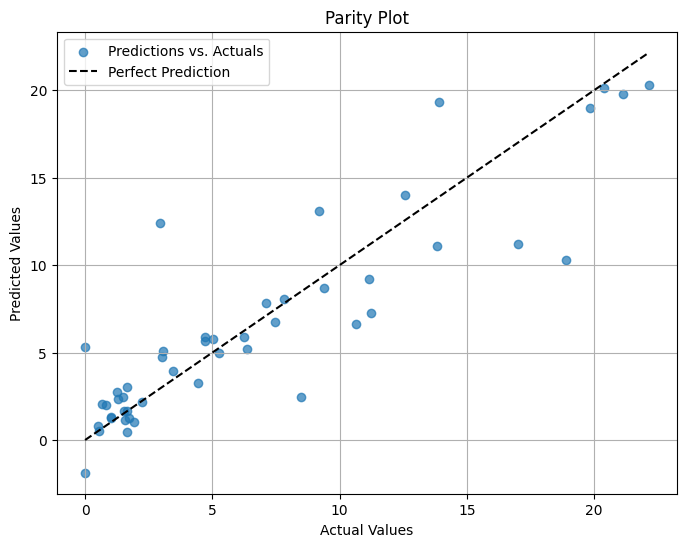

In [17]:
import matplotlib.pyplot as plt

# Generate parity plot
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.7, label='Predictions vs. Actuals')
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--', label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Print the actual noise parameter
print('Noise std dev:', likelihood.noise.sqrt().item())

# Print the actual values of the mean, outputscale, and lengthscale parameters
for name, module in model.named_modules():
    if hasattr(module, 'raw_noise'):
        print(f'name: {name} noise: {module.noise.item()}')
    if hasattr(module, 'raw_constant'):
        print(f'name: {name} constant: {module.constant.item()}')
    if hasattr(module, 'raw_outputscale'):
        print(f'name: {name} outputscale: {module.outputscale.item()} squared units')
    if hasattr(module, 'base_kernel') and hasattr(module.base_kernel, 'raw_lengthscale'):
        print(f'name: {name} lengthscale: {module.base_kernel.lengthscale.detach().numpy()}')

import math

def inverse_scale(lengthscale, bounds, target):
    original_lengthscale = bounds[0] + ((lengthscale - target[0]) * (bounds[1] - bounds[0]) / (target[1] - target[0]))
    return original_lengthscale

def inverse_scale_log(lengthscale, bounds, target):
    original_lengthscale = math.exp(math.log(bounds[0]) + ((lengthscale - target[0]) * (math.log(bounds[1]) - math.log(bounds[0])) / (target[1] - target[0])))
    return original_lengthscale

lengthscales_np = model.covar_module.base_kernel.lengthscale.detach().numpy()

voltage_lengthscale_original = inverse_scale(lengthscales_np[0][0], (0.8, 1.8), (0, 1))
time_lengthscale_original = inverse_scale_log(lengthscales_np[0][1], (1, 100), (0, 1))
concentration_lengthscale_original = inverse_scale_log(lengthscales_np[0][2], (0.01, 0.1), (0, 1))

print(f"Original Voltage Lengthscale: {voltage_lengthscale_original} V")


Noise std dev: 1.1032748222351074
name: likelihood noise: 1.2172152996063232
name: likelihood.noise_covar noise: 1.2172152996063232
name: mean_module constant: 5.945511341094971
name: covar_module outputscale: 23.508365631103516 squared units
name: covar_module lengthscale: [[0.21892327 0.31667724 0.36906865]]
Original Voltage Lengthscale: 1.018923270702362 V


C:\Users\harle\AppData\Local\Temp\ipykernel_17704\3204888164.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


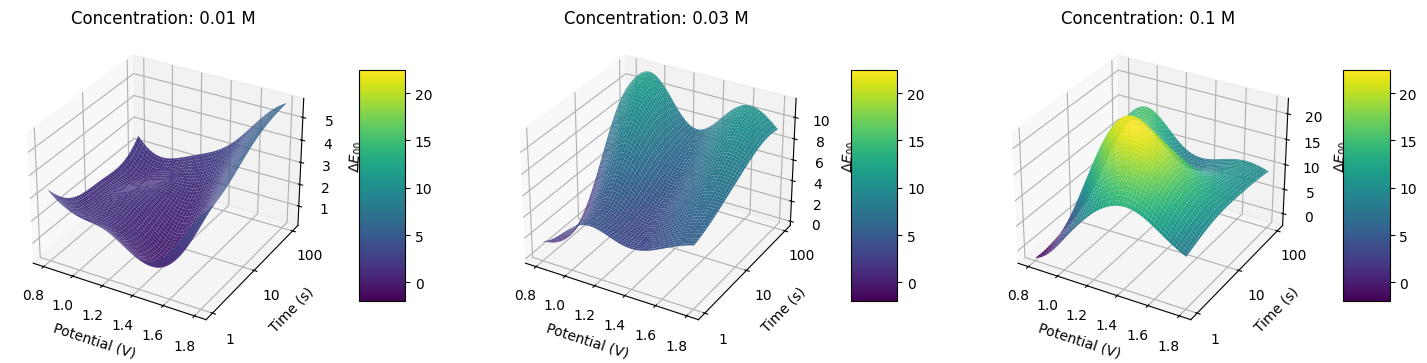

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define your concentration levels and ranges for voltage and original time
concentration_levels = [0.01, 0.03, 0.1]
voltage_range = np.linspace(0.8, 1.8, 100)
log_time_range = np.linspace(np.log(1), np.log(100), 100)
V, LogT = np.meshgrid(voltage_range, log_time_range)
T = np.exp(LogT)  # Convert back to original time for model input
voltage_bounds, time_bounds, concentration_bounds = (0.8, 1.8), (1, 100), (0.01,0.1)
voltage_target, time_target, concentration_target = (0,1), (0,1), (0,1)
# Store all predictions here to find global min and max
all_predictions = []

for concentration in concentration_levels:
    inputs_grid = np.stack((V.ravel(), T.ravel(), np.full(V.size, concentration)), axis=-1)
    inputs_scaled = scale_inputs(inputs_grid, voltage_bounds, time_bounds, concentration_bounds, voltage_target, time_target, concentration_target)
    inputs_tensor = torch.tensor(inputs_scaled, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        predictions = model(inputs_tensor).mean.numpy().reshape(V.shape)
    all_predictions.append(predictions)

# Find global min and max across all plots for consistent color scaling
global_min = min([pred.min() for pred in all_predictions])
global_max = max([pred.max() for pred in all_predictions])

fig, axs = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(18, 6))

for i, concentration in enumerate(concentration_levels):
    # Plot using the log-scaled time for the y-axis with a common color scale
    surf = axs[i].plot_surface(V, LogT, all_predictions[i], cmap='viridis', edgecolor='none', vmin=global_min, vmax=global_max)
    axs[i].set_title(f'Concentration: {concentration} M')
    axs[i].set_xlabel('Potential (V)')
    axs[i].set_ylabel('Time (s)')
    axs[i].set_zlabel(r'$\Delta E_{00}$')
    fig.colorbar(surf, ax=axs[i], shrink=0.5, aspect=5, pad=0.1)
    axs[i].set_yticks(np.log([1, 10, 100]))
    axs[i].set_yticklabels(['1', '10', '100'])

plt.tight_layout()
plt.show()

In [20]:
model.eval()
likelihood.eval()
def generate_and_scale_lhs_points(num_points, voltage_target=(0, 1), time_target=(0, 1), concentration_target=(0, 1), concentrations=[]):
    """
    Generates and scales the LHS prediction points.
    
    Args:
    - concentration: 
        
    Returns:
    - combined_samples: A numpy array of the LHS prediction points, scaled to specified bounds.
    """
    combined_samples = []
    for concentration in concentrations:
        sampler = qmc.LatinHypercube(d=2) 
        samples = sampler.random(n=num_points)
        
        # Directly scale samples for voltage and time according to the new target bounds
        # Scale voltage to (0, 1)
        samples[:, 0] = voltage_target[0] + (samples[:, 0] * (voltage_target[1] - voltage_target[0]))
        
        # Scale time to (0, 1)
        samples[:, 1] = time_target[0] + (samples[:, 1] * (time_target[1] - time_target[0]))

        # This assumes concentrations are already within some understood bounds or are being directly mapped
        scaled_concentration = np.full((num_points, 1), concentration_target[0] + (concentration - 0.01) * (concentration_target[1] - concentration_target[0]) / (0.1 - 0.01))
        
        # Append scaled concentration to samples
        samples_with_concentration = np.hstack((samples, scaled_concentration))
        combined_samples.append(samples_with_concentration)
        
    # Combine samples from all concentrations into a single array
    combined_samples = np.vstack(combined_samples)
    return combined_samples

# Configuration for generating and scaling LHS points
voltage_target = (0, 1)
time_target = (0, 1)
concentration_target = (0, 1)
concentrations = [0.027, 0.023, 0.020, 0.017, 0.013, 0.010, 0.085, 0.070, 0.055, 0.040, 0.025, 0.030, 0.100, 0.088, 0.077, 0.065, 0.053, 0.042]
num_points_per_concentration = 500

# Generate and scale LHS points
test_points_scaled = generate_and_scale_lhs_points(num_points_per_concentration, voltage_target, time_target, concentration_target, concentrations)

# Convert to PyTorch tensor for use in model
test_x_scaled = torch.tensor(test_points_scaled, dtype=torch.float32)

# Assuming 'train_y' contains your observed target values and you're looking for the maximum.
current_best_response = train_y.max().item()

def expected_improvement(model, test_points_scaled, current_best, likelihood):
    """
    Calculates the Expected Improvement at the test points.
    
    Args:
    - model: The trained GP model.
    - test_points: Test points to evaluate (torch.Tensor).
    - current_best: The current best observed response.
    - likelihood: The likelihood used in the GP model.
    
    Returns:
    - EI: A numpy array of expected improvements for each test point.
    """
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_points_scaled))
        mean = observed_pred.mean
        std_dev = observed_pred.stddev
        z = (mean - current_best) / std_dev
        ei = (mean - current_best) * torch.distributions.Normal(0, 1).cdf(z) + std_dev * torch.distributions.Normal(0, 1).log_prob(z).exp()
        return ei.numpy()


ei = expected_improvement(model, test_x_scaled, current_best_response, likelihood)
best_point_index = np.argmax(ei)
best_test_point = test_points_scaled[best_point_index]

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    best_test_point_tensor = torch.tensor(best_test_point, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    predicted_distribution = likelihood(model(best_test_point_tensor))
    predicted_mean = predicted_distribution.mean.item()
    predicted_stddev = predicted_distribution.stddev.item()

def convert_back_to_original(best_test_point_scaled, voltage_original=(0.8, 1.8), time_original=(1, 100), 
                             concentration_original=(0.01, 0.1), voltage_target=(0, 1), time_target=(0, 1), 
                             concentration_target=(0, 1)):
    # Invert voltage scaling
    voltage = voltage_original[0] + ((best_test_point_scaled[0] - voltage_target[0]) * 
                                     (voltage_original[1] - voltage_original[0]) / 
                                     (voltage_target[1] - voltage_target[0]))
    
    # Invert scaling for time
    time_scaled_back = time_target[0] + ((best_test_point_scaled[1] - time_target[0]) * 
                                         (time_target[1] - time_target[0]) / 
                                         (time_target[1] - time_target[0]))
    time = math.log(time_original[0]) + (time_scaled_back * (math.log(time_original[1]) - math.log(time_original[0])))
    time = math.exp(time)
    
    # Invert scaling for concentration
    concentration_scaled_back = concentration_target[0] + ((best_test_point_scaled[2] - concentration_target[0]) * 
                                                           (concentration_target[1] - concentration_target[0]) / 
                                                           (concentration_target[1] - concentration_target[0]))
    concentration = math.log(concentration_original[0]) + (concentration_scaled_back * (math.log(concentration_original[1]) - math.log(concentration_original[0])))
    concentration = math.exp(concentration)
    
    return np.array([voltage, time, concentration])


best_test_point_original = convert_back_to_original(best_test_point)

print("Best Test Point in Original Values:", best_test_point_original)
print("Predicted Response at Best Test Point:", predicted_mean)
print("Standard Deviation of Prediction:", predicted_stddev)


Best Test Point in Original Values: [1.19545046 6.32568975 0.1       ]
Predicted Response at Best Test Point: 22.421537399291992
Standard Deviation of Prediction: 1.418397307395935


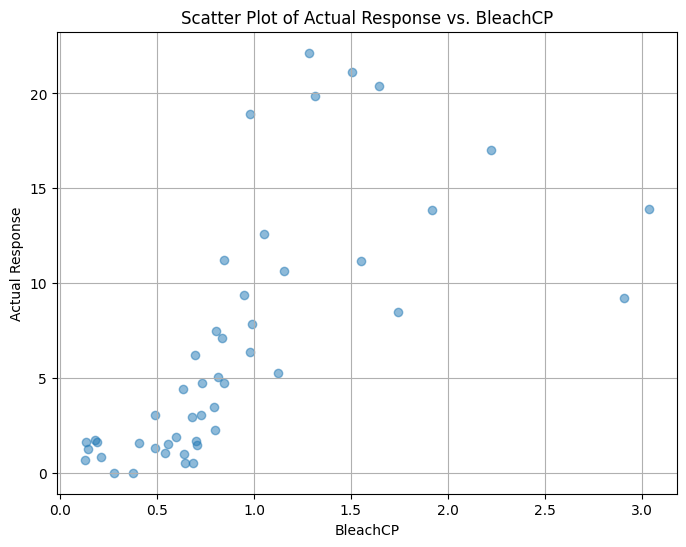

In [21]:
# Plot of actual responses vs. bleachCP
plt.figure(figsize=(8, 6))
plt.scatter(bleachCP, actuals, alpha=0.5)
plt.xlabel('BleachCP')
plt.ylabel('Actual Response')
plt.title('Scatter Plot of Actual Response vs. BleachCP')
plt.grid(True)
plt.show()

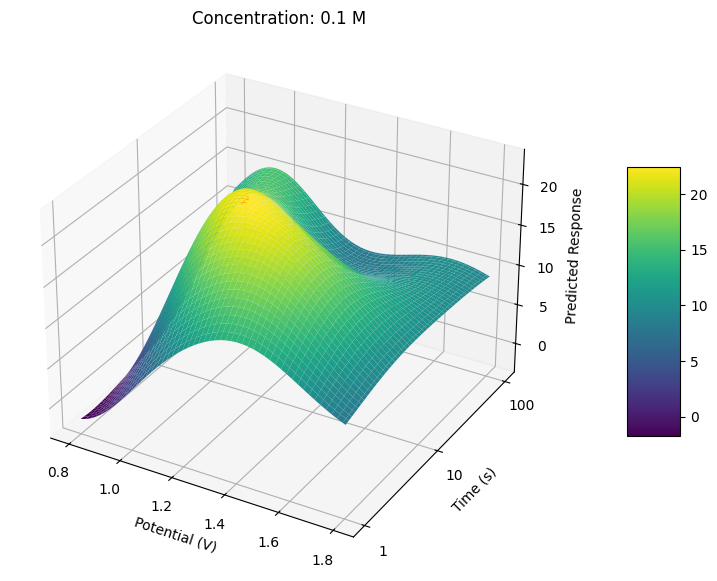

In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Generate the input grid for 0.1M concentration
concentration = 0.1  # 0.1M concentration
V, LogT = np.meshgrid(voltage_range, log_time_range)  # Assuming these are already defined
T = np.exp(LogT)  # Convert log-time back to original time scale

inputs_grid = np.stack((V.ravel(), T.ravel(), np.full(V.size, concentration)), axis=-1)

# Step 2: Scale the inputs (assuming `scale_inputs` is your scaling function)
inputs_scaled = scale_inputs(inputs_grid, voltage_bounds, time_bounds, concentration_bounds, 
                             voltage_target, time_target, concentration_target)

# Convert scaled inputs to tensor for model prediction
inputs_tensor = torch.tensor(inputs_scaled, dtype=torch.float32)

# Step 3: Predict with the model
model.eval()  # Assuming 'model' is your trained model
with torch.no_grad():
    predictions = model(inputs_tensor).mean.numpy().reshape(V.shape)

# Step 4: Plot the surface with the best test point
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot for predictions
surf = ax.plot_surface(V, LogT, predictions, cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.1)

ax.set_title('Concentration: 0.1 M')
ax.set_xlabel('Potential (V)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Predicted Response')  # Adjust label as needed

ax.set_yticks(np.log([1, 10, 100]))
ax.set_yticklabels(['1', '10', '100'])

# Assuming best_test_point_original matches the conditions for plotting
if np.isclose(best_test_point_original[2], 0.1, atol=0.01):
    log_time_best_point = np.log(best_test_point_original[1])
    ax.scatter(best_test_point_original[0], log_time_best_point, predictions.max(), color='red', s=50, depthshade=False)

plt.show()


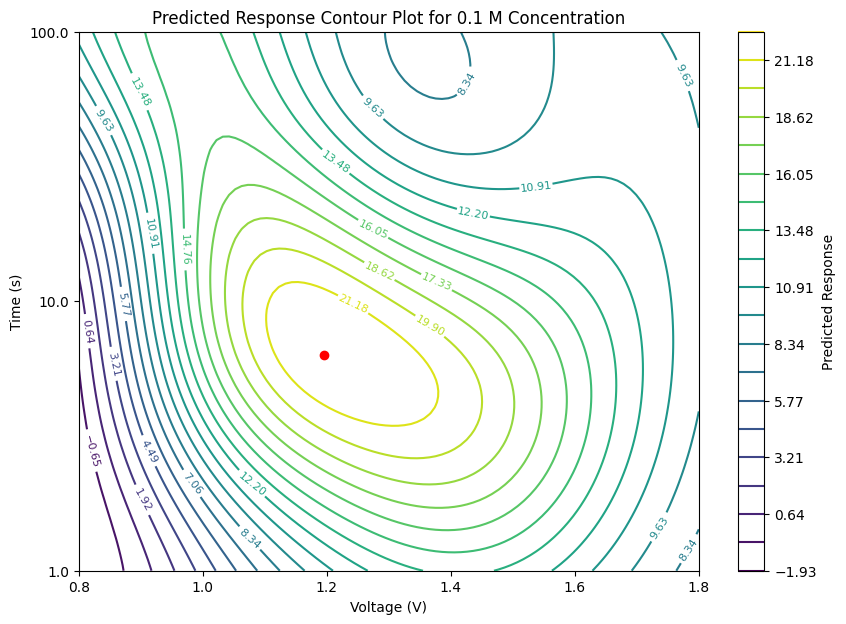

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Your predictions and voltage range (V) need to be defined here
# For illustration purposes, let's say predictions is a 2D array of your model's outputs
# and V and T have been defined as before

# Determine appropriate time ticks for log scale
time_ticks = np.log([1, 10, 100])  # Specify the time values you want to show as ticks
time_tick_labels = [f"{np.exp(tick):.1f}" for tick in time_ticks]  # Convert back to linear scale for labels

plt.figure(figsize=(10, 7))
# Create a contour plot with np.log(T) to represent log-scaled time on y-axis
CS = plt.contour(V, np.log(T), predictions, levels=np.linspace(predictions.min(), predictions.max(), num=20))
plt.clabel(CS, inline=True, fontsize=8)
plt.title('Predicted Response Contour Plot for 0.1 M Concentration')
plt.xlabel('Voltage (V)')
plt.ylabel('Time (s)')

# Set the custom ticks and labels to represent log-scaled time accurately
plt.yticks(time_ticks, time_tick_labels)

plt.colorbar(CS, label='Predicted Response')

# Include this line if you want to show the best test point
plt.scatter(best_test_point_original[0], np.log(best_test_point_original[1]), color='red', label='Best Test Point')

plt.show()
